# Paper Plots

In [1]:
# This notebook contains the code for making the plots in the offline analysis paper

In [2]:
#Import same packages as AN_plots
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import scipy
from plot_utils import *
import fill_utils

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
sourceDir = '/work/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(sourceDir+'*.pkl') # Read in the pkl files

filenames_offline_data = [f for f in infile_names if ("combined_data_november_v2." in f) and ('JetHT' in f)] # Only take the correct datafiles with the correct tag

plots = loader(filenames_offline_data, exclude_low_bins=True,auto_lumi = True)['data'] # Get dictionary with histograms 

# for f in filenames_offline_data:
#     print(f)

## ABCD region distribution plot

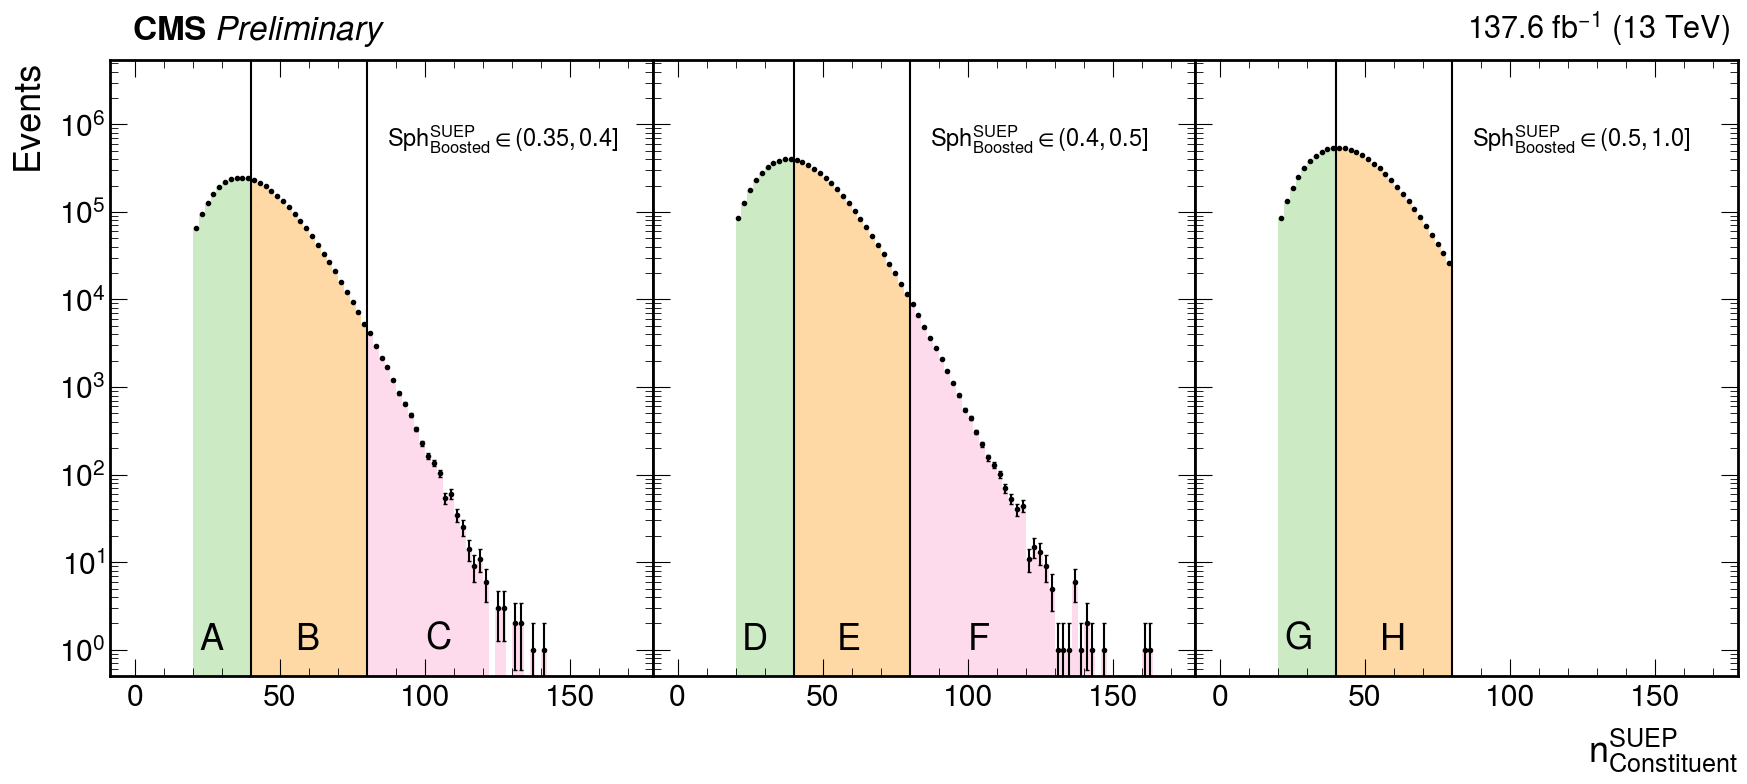

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 8), sharey=True,sharex=True) #Plot 3 subplots
fig.subplots_adjust(wspace=0) #Plot 
(ax1, ax2, ax3) = axes

h = plots['A_SUEP_nconst_Cluster']

slicing = [0.0,40,80,170] #The boundary of the ABCD regions 
label_positions = [22,55,100] #The positions of the letters
colormap = plt.cm.get_cmap('Pastel1')
colors = [colormap(0.3),colormap(0.5),colormap(0.8)]
ymax = 0

# Plot the distributions in every region
regions = {'A':(ax1,0),
           'B':(ax1,1),
           'C':(ax1,2),
           'D':(ax2,0),
           'E':(ax2,1),
           'F':(ax2,2),
           'G':(ax3,0),
           'H':(ax3,1)}


for letter, (axis,i) in regions.items():
    h = plots[letter + '_SUEP_nconst_Cluster']
    h = h[slicing[i]*1j:slicing[i+1]*1j]
    yerr = h.variances()**0.5 #Take error
    y, x = h.to_numpy()

    axis.stairs(y,x,fill=True,color=colors[i])
    
    centers = (x + np.roll(x,1))/2
    centers = centers[1:] #centers of bins
    axis.errorbar(centers,y,yerr=yerr,linestyle='',c='black',capsize=1.5,fmt ='.')
    axis.text(label_positions[i],1,str(letter))
    ymax = max(np.append(y,ymax))
    
ytop = ymax *10 # The upper limit for the yaxis

#Adjust the figure and add labels 
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(0.5,ytop)
    ax.vlines([40,80],0.5,ytop,color='black') #Take bin edges
    

ax1.set_ylabel('Events',labelpad=10)
ax3.set_xlabel('$n^{SUEP}_{Constituent}$', labelpad=10, loc='right')

ax1.text(87,ymax,r'$Sph^{SUEP}_{Boosted} \in (0.35,0.4]$',fontsize=17)
ax2.text(87,ymax,r'$Sph^{SUEP}_{Boosted} \in (0.4,0.5]$',fontsize=17)
ax3.text(87,ymax,r'$Sph^{SUEP}_{Boosted} \in (0.5,1.0]$',fontsize=17)

#Add CMS statements
cms = ax.text(
    -375, ytop*1.7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)

lumi = ax.text(
    85, ytop*1.7, r"%.1f fb$^{-1}$ ($13$ TeV)" % round(lumiLabel('2016')+lumiLabel('2017')+lumiLabel('2018'),1),
    fontsize=22,
)
fig.tight_layout()
plt.autoscale()

# plt.savefig('/home/submit/pvanstee/ABCD_region_plot/SUEPCoffea_dask/plotting/all_region_plot.pdf',format='pdf',bbox_inches='tight')
